 # Deuteron
 The deuteron is the bound state of a proton and a neutron. In order to estimate the binding energy of the system, there are two main approaches one could follow involving a simulation on a quantum computer. 
 
 Here's a list of contents:
1. [First approach](#first-approach)
    1. [Exact energies](#exact-energies)
    2. [Simulated energies](#simulated-energies)
       1. [N=2 simulation](#simulation-on-2-qubits)
       2. [N=3 simulation](#simulation-on-3-qubits)
       3. [Fit for ground state energy](#fit-for-ground-state-energy)

## First approach
The creation and destruction operators of the deuteron are mapped into combinations of Pauli gates. The ladder operators $a_n^\dagger$ and $a_n$ create and annihilate a deuteron in the harmonic oscillator state $|n \rangle$. The Hamiltonian (from pionless effective field theory) is of the form

$$
H_N = \sum_{n,n'=0}^{N-1} \langle n' | T+V | n \rangle a_{n'}^\dagger a_n
$$

where the matrix elements are given by

$$
\langle n' |T|n\rangle = \frac{\hbar \omega}{2}\left[(2n+3/2)\delta_n^{n'}- \sqrt{n(n+ 1/2)}\delta_n^{n'+1}-\sqrt{(n+1)(n+3/2)}\delta_n^{n'-1} \right]
$$

$$
\langle n' |V|n\rangle = V_0 \delta_n^0 \delta_n^{n'}
$$

with $\hbar \omega= 7 \,\mathrm{MeV}$ and $V_0 =-5.68658111\,\mathrm{MeV}$.

Thanks to the Jordan-Wigner transformation, the Hamiltonian is expressed in terms of Pauli matrices, allowing us to map it into a quantum circuit with $N$ qubits. By calculating the variational ground state energies for $H_1$, $H_2$ and $H_3$, one can extrapolate the infinite-basis binding energy using the harmonic oscillator variant of Lüscher formula.

The reduced mass of the system is defined as $\mu = \frac{m_p m_n}{m_p + m_n}$, where $m_p$ and $m_n$ are the masses (in Mev) of the proton and the neutron respectively.

In [17]:
import math
import numpy as np
from qiskit import QuantumCircuit, transpile, execute, BasicAer
from qiskit.quantum_info import Statevector, Pauli
from qiskit_aer import Aer
from qiskit.opflow import X, Y, Z, I, CircuitStateFn
from qiskit.visualization import plot_histogram
pi = math.pi
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from scipy.optimize import curve_fit
import re
# Deuteron parameters
m_p = 938.2720813 # MeV / c^2
m_n = 939.5654252 # MeV / c^2
mu = (m_p*m_n)/(m_p + m_n) # MeV / c^2
hbar_c = 197.326980 # Mev fm

### Exact energies
By using the Qiskit Statevector method one can diagonalize the Hamiltonian and extract the exact energies of the system. Note how the use of the Qiskit library here is merely a matter of choice: what is happening is nothing more than complex matrix and vector moltiplication. These energies are going to be the reference point to compare the results of the actual simulation. This whole "Exact energies" chapter can be seen as a preliminary consistency check for the work done in the chapter "Simulated energies".

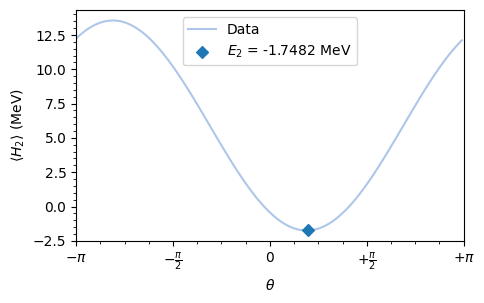

Lowest trial energy for N=1:  -0.4366 MeV
Lowest trial energy for N=2:  -1.7482 MeV
Lowest trial energy for N=3:  -2.0456 MeV


In [18]:
# Define deuterion Hamiltonian in the computational basis
Hamilt_1 = 0.218291 * (Z-I)
Hamilt_2 = (5.906709 * I^I) + (0.218291 * I^Z) - (6.125 * Z^I) - (2.143304 * X^X) - (2.143304 * Y^Y)
Hamilt_3 = (5.906709 * I^I^I) + (0.218291 * I^I^Z) - (6.125 * I^Z^I) - (2.143304 * I^X^X) - (2.143304 * I^Y^Y) +\
            + 9.625*(I^I^I) -9.625*(Z^I^I) - 3.913119*(X^X^I)  - 3.913119*(Y^Y^I)
# The ground state for H_1 is obtained as <1|H_1|1>, no need to use variational method
state = Statevector.from_int(1,2)
E_1_ex =  state.expectation_value(Hamilt_1).real 

# Loop over variational parameter theta for cal culation of <H_2>
theta = np.arange(-3.14,+3.14,0.05)
eta =  np.arange(-3.14,+3.14,0.05)
exp_val_2 = np.empty(len(theta))
exp_val_3 = np.empty((len(theta),len(eta)))
for kk in range(0, len(theta)):
    # Create a Quantum Circuit acting on the q register, default both in the state |0>
    circuit2 = QuantumCircuit(2)

    # Add X gate to qubit 0
    circuit2.x(0)

    # Rotation around y axis on qubit 1
    circuit2.ry(theta[kk], 1)

    # Add CNOT, control q1, target q0
    circuit2.cx(1,0)

    # Initialize state
    state2= Statevector.from_int(0, 4)

    # Evolve the state by the quantum circuit
    state2 = state2.evolve(circuit2)

    # Calculate expectation value
    exp_val_2[kk]=state2.expectation_value(Hamilt_2).real

    # loop over variational parameter eta for <H_3>
    for jj in range(0, len(eta)):
        # Create a Quantum Circuit acting on the q register, default all 3 qubits in the state |0>
        circuit3 = QuantumCircuit(3)

        # Add X gate to qubit 0
        circuit3.x(0)

        # Rotation around y axis on qubit 1
        circuit3.ry(eta[jj], 1)

        # Rotation around y axis on qubit 2
        circuit3.ry(theta[kk], 2)

        # Add CNOT, control q2, target q0
        circuit3.cx(2,0)

        # Add CNOT, control q0, target q1
        circuit3.cx(0,1)

        # Rotation around y axis on qubit 1
        circuit3.ry(-eta[jj], 1)

        # Add CNOT, control q0, target q1
        circuit3.cx(0,1)

        # Add CNOT, control q1, target q0
        circuit3.cx(1,0)

        # Initialize state
        state3= Statevector.from_int(0, 8)

        # Evolve the state by the quantum circuit
        state3 = state3.evolve(circuit3)

        # Calculate expectation value
        exp_val_3[kk, jj]=state3.expectation_value(Hamilt_3).real


# Lowest trial energy for <H_2> and <H_3>
E_2_ex = exp_val_2.min()
E_3_ex = exp_val_3.min()

# Plot of energy as a function of theta
# Plot style options
cmap = plt.get_cmap('tab20')
w = 5
h = 3
fontsize = 12
lbl = '$E_2$ = ' + str(round(E_2_ex,4))+' MeV'
fig = plt.figure(figsize=(w,h))
ax = fig.add_subplot(111)
ax.plot(theta, exp_val_2, color = cmap(1), label = 'Data')
ax.scatter(theta[np.where(exp_val_2 == E_2_ex)[0]], E_2_ex, color = cmap(0), zorder=5, marker='D', label = lbl)
unit = 0.5
x_tick = np.arange(-1, +1 + unit, unit)
x_label = [r'$-\pi $', r'$-\frac{\pi}{2}$', r'$0$', r'$+\frac{\pi}{2}$', r'$+\pi$']
ax.set_xlim(theta.min(), theta.max())
ax.set_xticks(x_tick * pi)
ax.set_xticklabels(x_label, fontsize=10)
ax.minorticks_on()
plt.legend(loc='upper center')
plt.xlabel("$\\theta$")
plt.ylabel("$\\langle H_2 \\rangle$ (MeV)")
plt.show()
# Results
print('Lowest trial energy for N=1: ', round(E_1_ex, 4), 'MeV')
print('Lowest trial energy for N=2: ', round(E_2_ex, 4), 'MeV')
print('Lowest trial energy for N=3: ', round(E_3_ex, 4), 'MeV')

Fit for $E_N$ using Lüscher formula

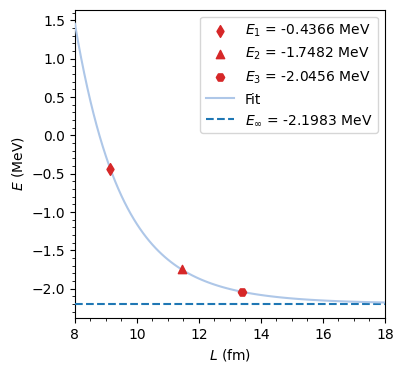

Infinite-basis extrapolated binding energy:  -2.1983 MeV ( 1.0 % off)


In [19]:
# List of trial energies
E_data = np.array([E_1_ex, E_2_ex, E_3_ex])

# Effective hard-wall radius for N=1, N=2 & N=3
L = np.array([9.14, 11.45, 13.38])  # fm

# Harmonic oscillator variant of Lüscher formula
#   k: bound state momentum fm^(-1)
#   gamma: asymptotic normalization coefficient fm^(-1/2)
def luscher(l, k, gamma):
    return -(hbar_c*hbar_c*k*k/(2*mu))*(1 - 2*gamma*gamma*np.exp(-2*k*l)/k - 4*(gamma**4)*l*np.exp(-4*k*l)/k)
            #hbar_c*hbar_c*k*gamma*gamma*(1- gamma*gamma/k - (gamma**4)/(4*k*k) + 2*w*k*(gamma**4))*np.exp(-4*k*l)/mu

# Fit to k and gamma
[k, gamma], cov = curve_fit(luscher, L, E_data)

# Fit plot
E_exact = -2.22 #MeV
ll = np.arange(8,18.0001,0.1)
lbl = '$E_\infty$ = ' + str(round(-hbar_c*hbar_c*k*k/(2*mu),4)) + ' MeV'
lbl1 = '$E_1$ = ' + str(round(E_data[0],4))+ ' MeV'
lbl2 = '$E_2$ = ' + str(round(E_data[1],4))+ ' MeV'
lbl3 = '$E_3$ = ' + str(round(E_data[2],4))+ ' MeV'
cmap = plt.get_cmap('tab20')
w = 4
h = 4
plt.figure(figsize=(w,h))
plt.scatter(L[0], E_data[0], color = cmap(6), marker = 'd', zorder=5, label = lbl1)
plt.scatter(L[1], E_data[1], color = cmap(6), marker = '^', zorder=5, label = lbl2)
plt.scatter(L[2], E_data[2], color = cmap(6), marker = 'H', zorder=5, label = lbl3)
plt.plot(ll, luscher(ll, k, gamma), color = cmap(1), zorder= 4, label= 'Fit')
plt.plot(ll, -hbar_c*hbar_c*k*k/(2*mu)*np.ones(len(ll)), '--', color = cmap(0), zorder = 3, label = lbl)
plt.legend()
plt.xlim(ll.min(), ll.max())
plt.minorticks_on()
plt.xlabel('$L$ (fm)')
plt.ylabel('$E$ (MeV)')
plt.show()
# Results
E_gs_0 = -hbar_c*hbar_c*k*k/(2*mu)
print('Infinite-basis extrapolated binding energy: ', round(E_gs_0,4), 'MeV (', round(np.abs(100*(E_exact -E_gs_0)/E_exact),1),'% off)' )

### Simulated energies
The Qiskit Qasm simulator is used to simulate the outcomes of an experiment measuring the different Pauli terms of the Hamiltonian under study. Note how the Pauli operators of the type $X \otimes X + Y\otimes Y$ for the 2 qubits circuit and $X \otimes X \otimes I + Y\otimes Y \otimes I$ for the 3 qubits circuit are measured all at once with a Bell measurement. The errors on the mean values are calculated assuming that each measurement can be seen as a sample from a binomial probability distribution.

In [20]:
# Simulator setup
Aer.backends()
# Transpile for simulator
simulator = Aer.get_backend('qasm_simulator')

# Hamiltonians
Hamilt_1 = 0.218291 * (Z-I)
Hamilt_2 = (5.906709 * I^I) + (0.218291 * I^Z) - (6.125 * Z^I) - (2.143304 * X^X) - (2.143304 * Y^Y)
Hamilt_3 = (5.906709 * I^I^I) + (0.218291 * I^I^Z) - (6.125 * I^Z^I) - (2.143304 * I^X^X) - (2.143304 * I^Y^Y) +\
            + 9.625*(I^I^I) -9.625*(Z^I^I) - 3.913119*(X^X^I)  - 3.913119*(Y^Y^I)

#Measurement circuit ZZ
qc_meas_ZZ = QuantumCircuit(2)
qc_meas_ZZ.measure_all()
# Measurement circuit YY    
qc_meas_YY = QuantumCircuit(2)
qc_meas_YY.sdg(0)
qc_meas_YY.h(0)
qc_meas_YY.sdg(1)
qc_meas_YY.h(1)
qc_meas_YY.measure_all()
# Measurement circuit XX
qc_meas_XX = QuantumCircuit(2)
qc_meas_XX.h(0)
qc_meas_XX.h(1)
qc_meas_XX.measure_all()
#Measurement circuit Bell states
qc_meas_Bell = QuantumCircuit(2)
qc_meas_Bell.cx(0,1)
qc_meas_Bell.h(0)
qc_meas_Bell.measure_all()
#Measurement circuit Z
qc_meas_ZZZ = QuantumCircuit(3)
qc_meas_ZZZ.measure_all()
# Measurement circuit YYY    
qc_meas_YYY = QuantumCircuit(3)
qc_meas_YYY.sdg(0)
qc_meas_YYY.h(0)
qc_meas_YYY.sdg(1)
qc_meas_YYY.h(1)
qc_meas_YYY.sdg(2)
qc_meas_YYY.h(2)
qc_meas_YYY.measure_all()
# Measurement circuit XXX
qc_meas_XXX = QuantumCircuit(3)
qc_meas_XXX.h(0)
qc_meas_XXX.h(1)
qc_meas_XXX.h(2)
qc_meas_XXX.measure_all()

# Function that assigns 0 value to undefined keys in the counts dictionary
def check_counts_1(dic):
    if '1' not in dic:
        dic['1'] = 0
    if '0' not in dic:
        dic['0'] = 0

def check_counts_2(dic):
    if '11' not in dic:
        dic['11'] = 0
    if '10' not in dic:
        dic['10'] = 0
    if '01' not in dic:
        dic['01'] = 0
    if '00' not in dic:
        dic['00'] = 0

def check_counts_3(dic):
    if '111' not in dic:
        dic['111'] = 0
    if '101' not in dic:
        dic['101'] = 0
    if '011' not in dic:
        dic['011'] = 0
    if '001' not in dic:
        dic['001'] = 0
    if '110' not in dic:
        dic['110'] = 0
    if '100' not in dic:
        dic['100'] = 0
    if '010' not in dic:
        dic['010'] = 0
    if '000' not in dic:
        dic['000'] = 0

#### Simulation on 2 qubits

N=2 binding energy:  -1.7709  +-  0.0195  MeV


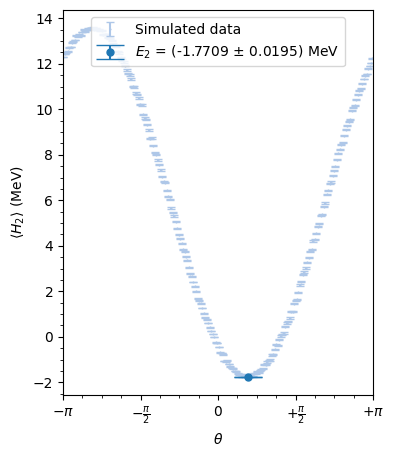

In [31]:
# Number of runs per simulation
shots = 10000

theta = np.arange(-3.14,+3.14,0.03)
exp_val_2 = np.empty(len(theta))
dexp_val_2 = np.empty(len(theta))
for kk in range(0, len(theta)):
    # Create a Quantum Circuit acting on the q register, default both in the state |0>
    qc2 = QuantumCircuit(2)

    # Add X gate to qubit 0
    qc2.x(0)

    # Rotation around y axis on qubit 1
    qc2.ry(theta[kk], 1)

    # Add CNOT, control q1, target q0
    qc2.cx(1,0)

    # Add measurement circuit
    qc2_ZZ = qc2.compose(qc_meas_ZZ)
    qc2_Bell = qc2.compose(qc_meas_Bell)
    # Transpile for simulator
    comp_qc2_ZZ = transpile(qc2_ZZ, simulator)
    comp_qc2_Bell = transpile(qc2_Bell, simulator)
    # Run and get counts
    job_ZZ = simulator.run(comp_qc2_ZZ, shots = shots)
    job_Bell = simulator.run(comp_qc2_Bell, shots = shots)
    counts_ZZ =   job_ZZ.result().get_counts(comp_qc2_ZZ)
    counts_Bell =   job_Bell.result().get_counts(comp_qc2_Bell)
    # Check keys
    check_counts_2(counts_ZZ)
    check_counts_2(counts_Bell)
    # Calculate expectation values
    exp_IZ = (counts_ZZ['10'] + counts_ZZ['00'] - counts_ZZ['11'] - counts_ZZ['01'])/shots
    exp_ZI =  (counts_ZZ['01'] + counts_ZZ['00'] - counts_ZZ['11']- counts_ZZ['10'])/shots
    exp_ZZ = (counts_ZZ['00'] + counts_ZZ['11'] - counts_ZZ['01'] - counts_ZZ['10'])/shots
    exp_XX_YY = 2*(counts_Bell['10'] - counts_Bell['11'])/shots 
    exp_val_2[kk] = 0.218291*exp_IZ - 6.125*exp_ZI + 5.906709 -2.143304*(exp_XX_YY)

    # Calculate variance with binomial distribution
    var_IZ = (counts_ZZ['10'] + counts_ZZ['00'])*(counts_ZZ['11'] + counts_ZZ['01'])/(shots**2)
    var_ZI = (counts_ZZ['01'] + counts_ZZ['00'])*(counts_ZZ['11'] + counts_ZZ['10'])/(shots**2)
    var_XX_YY = (counts_Bell['10'])*(counts_Bell['11'])/(shots**2)
    var_tot = (0.218291**2)*var_IZ + (6.125**2)*var_ZI + (2.143304**2)*var_XX_YY
    std_counts = np.sqrt(var_tot)
    dexp_val_2[kk]= std_counts/np.sqrt(shots)

# Lowest trial energy for <H_2>
E_2 = exp_val_2.min()
dE_2= dexp_val_2[np.where(exp_val_2 == E_2)][0].astype(E_2)
print('N=2 binding energy: ', round(E_2,4), ' +- ', round(dE_2,4), ' MeV')

# Plot of energy as a function of theta  <H_2>(theta)
# Plot style options
cmap = plt.get_cmap('tab20')
w = 4
h = 5
fontsize = 12
lbl = '$E_2$ = (' + str(round(E_2,4)) + ' $\pm$ ' + str(round(dE_2,4)) + ') MeV'
fig = plt.figure(figsize=(w,h))
ax = fig.add_subplot(111)
ax.errorbar(theta, exp_val_2, yerr = dexp_val_2, color = cmap(1), fmt="o", ms=0.5, capsize = 3, label = 'Simulated data')
ax.errorbar(theta[np.where(exp_val_2 == E_2)[0]], E_2, yerr = dE_2, color = cmap(0), fmt="o",zorder=5, ms=5, capsize = 10, label = lbl)
unit = 0.5
x_tick = np.arange(-1, +1 + unit, unit)
x_label = [r'$-\pi $', r'$-\frac{\pi}{2}$', r'$0$', r'$+\frac{\pi}{2}$', r'$+\pi$']
ax.set_xlim(theta.min(), theta.max())
ax.set_xticks(x_tick * pi)
ax.set_xticklabels(x_label, fontsize=10)
ax.minorticks_on()
plt.legend(loc='upper center')
plt.xlabel("$\\theta$")
plt.ylabel("$\\langle H_2 \\rangle$ (MeV)") 
plt.show()

#### Simulation on 3 qubits

N=3 binding energy:  -2.0789  +-  0.0291  MeV


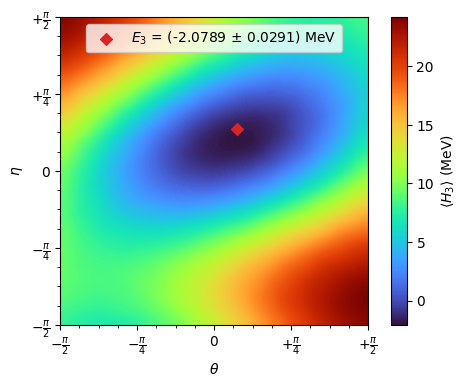

In [33]:
# Number of runs per simulation
shots = 10000

theta = np.arange(-3.14/2.,3.14/2. + 0.1, 0.1)
eta = np.arange(-3.14/2.,3.14/2. + 0.1, 0.1)
exp_val_3 = np.empty((len(theta), len(eta)))
dexp_val_3 = np.empty((len(theta), len(eta)))
for kk in range(0, len(theta)):
    for jj in range(0, len(eta)):
        # Create a Quantum Circuit acting on the q register, default all 3 qubits in the state |0>
        qc3 = QuantumCircuit(3)

        # Add X gate to qubit 0
        qc3.x(0)

        # Rotation around y axis on qubit 1
        qc3.ry(eta[jj], 1)

        # Rotation around y axis on qubit 2
        qc3.ry(theta[kk], 2)

        # Add CNOT, control q2, target q0
        qc3.cx(2,0)

        # Add CNOT, control q0, target q1
        qc3.cx(0,1)

        # Rotation around y axis on qubit 1
        qc3.ry(-eta[jj], 1)

        # Add CNOT, control q0, target q1
        qc3.cx(0,1)

        # Add CNOT, control q1, target q0
        qc3.cx(1,0)
        
        # Add measurement circuit
        qc3_ZZZ = qc3.compose(qc_meas_ZZZ)
        qc3_YYY = qc3.compose(qc_meas_YYY)
        qc3_XXX = qc3.compose(qc_meas_XXX)
        qc3_Bell = qc3.compose(qc_meas_Bell, qubits=[0,1])
        qc3_Bell2 = qc3.compose(qc_meas_Bell, qubits=[1,2])
        # Transpile for simulator
        comp_qc3_ZZZ = transpile(qc3_ZZZ, simulator)
        comp_qc3_YYY = transpile(qc3_YYY, simulator)
        comp_qc3_XXX = transpile(qc3_XXX, simulator)
        comp_qc3_Bell = transpile(qc3_Bell, simulator)
        comp_qc3_Bell2 = transpile(qc3_Bell2, simulator)
        # Run and get counts
        job_ZZZ = simulator.run(comp_qc3_ZZZ, shots = shots)
        job_YYY = simulator.run(comp_qc3_YYY, shots = shots)
        job_XXX = simulator.run(comp_qc3_XXX, shots = shots)
        job_Bell = simulator.run(comp_qc3_Bell, shots = shots)
        job_Bell2 = simulator.run(comp_qc3_Bell2, shots = shots)
        counts_ZZZ =   job_ZZZ.result().get_counts(comp_qc3_ZZZ)
        counts_YYY =   job_YYY.result().get_counts(comp_qc3_YYY)
        counts_XXX =   job_XXX.result().get_counts(comp_qc3_XXX)
        counts_Bell = job_Bell.result().get_counts(comp_qc3_Bell)
        counts_Bell2 = job_Bell2.result().get_counts(comp_qc3_Bell2)
        # Check keys
        check_counts_3(counts_ZZZ)
        check_counts_3(counts_YYY)
        check_counts_3(counts_XXX)
        check_counts_2(counts_Bell)
        check_counts_2(counts_Bell2)
        # Calculate expectation values
        exp_IIZ = (counts_ZZZ['110'] + counts_ZZZ['100'] + counts_ZZZ['010'] + counts_ZZZ['000'] \
                   -counts_ZZZ['111'] - counts_ZZZ['101'] - counts_ZZZ['011'] - counts_ZZZ['001'] )/shots
        exp_IZI = (counts_ZZZ['000'] + counts_ZZZ['100'] + counts_ZZZ['001'] + counts_ZZZ['101'] \
                   -counts_ZZZ['010'] - counts_ZZZ['110'] - counts_ZZZ['011'] - counts_ZZZ['111'] )/shots
        exp_ZII = (counts_ZZZ['000'] + counts_ZZZ['001'] + counts_ZZZ['011'] + counts_ZZZ['010'] \
                   -counts_ZZZ['100'] - counts_ZZZ['101'] - counts_ZZZ['111'] - counts_ZZZ['110'] )/shots
        exp_IZZ = (counts_ZZZ['000'] + counts_ZZZ['011'] + counts_ZZZ['100'] + counts_ZZZ['111'] \
                   -counts_ZZZ['001'] - counts_ZZZ['010'] - counts_ZZZ['101'] - counts_ZZZ['110'] )/shots
        #exp_IXX = (counts_XXX['000'] + counts_XXX['011'] + counts_XXX['100'] + counts_XXX['111'] \
        #           -counts_XXX['001'] - counts_XXX['010'] - counts_XXX['101'] - counts_XXX['110'] )/shots
        #exp_IYY = (counts_YYY['000'] + counts_YYY['011'] + counts_YYY['100'] + counts_YYY['111'] \
        #           -counts_YYY['001'] - counts_YYY['010'] - counts_YYY['101'] - counts_YYY['110'] )/shots
        #exp_XXI = (counts_XXX['000'] + counts_XXX['110'] + counts_XXX['001'] + counts_XXX['111'] \
        #           -counts_XXX['100'] - counts_XXX['010'] - counts_XXX['101'] - counts_XXX['011'] )/shots
        #exp_YYI = (counts_YYY['000'] + counts_YYY['110'] + counts_YYY['001'] + counts_YYY['111'] \
        #           -counts_YYY['100'] - counts_YYY['010'] - counts_YYY['101'] - counts_YYY['011'] )/shots
        #exp_XIX = (counts_XXX['000'] + counts_XXX['101'] + counts_XXX['010'] + counts_XXX['111'] \
        #           -counts_XXX['100'] - counts_XXX['001'] - counts_XXX['110'] - counts_XXX['011'] )/shots
        #exp_YIY = (counts_YYY['000'] + counts_YYY['101'] + counts_YYY['010'] + counts_YYY['111'] \
        #           -counts_YYY['100'] - counts_YYY['001'] - counts_YYY['110'] - counts_YYY['011'] )/shots
        exp_I_XX_YY = 2*(counts_Bell['10'] - counts_Bell['11'])/shots 
        exp_XX_YY_I = 2*(counts_Bell2['10'] - counts_Bell2['11'])/shots 

        exp_val_3[kk][jj] = 15.531709 + (0.218291 * exp_IIZ) - (6.125 * exp_IZI) - 2.143304*(exp_I_XX_YY) \
                            -9.625*exp_ZII - 3.913119*(exp_XX_YY_I)
        # Calculate variance with binomial distribution
        var_IIZ = (counts_ZZZ['110'] + counts_ZZZ['100'] + counts_ZZZ['010'] + counts_ZZZ['000'])*\
                    (counts_ZZZ['111'] + counts_ZZZ['101'] + counts_ZZZ['011'] + counts_ZZZ['001'])/(shots**2)
        var_IZI = (counts_ZZZ['000'] + counts_ZZZ['100'] + counts_ZZZ['001'] + counts_ZZZ['101'])*\
                    (counts_ZZZ['010'] + counts_ZZZ['110'] + counts_ZZZ['011'] + counts_ZZZ['111'] )/(shots**2)
        var_ZII = (counts_ZZZ['000'] + counts_ZZZ['001'] + counts_ZZZ['011'] + counts_ZZZ['010'])*\
                    (counts_ZZZ['100'] + counts_ZZZ['101'] + counts_ZZZ['111'] + counts_ZZZ['110']  )/(shots**2)
        var_I_XX_YY = 4*(counts_Bell['10'])*(counts_Bell['11'])/(shots**2)
        var_XX_YY_I = 4*(counts_Bell2['10'])*(counts_Bell2['11'])/(shots**2)

        var_tot = (0.218291**2)*var_IIZ + (6.125**2)*var_IZI + (2.143304**2)*var_I_XX_YY \
                +(9.625**2)*var_ZII + (3.913119**2)*var_XX_YY_I

        #var_counts = 5.906709**2 + 2*5.906709*0.218291*exp_IIZ +\
        #    (-2)*5.906709*6.125*exp_IZI -2*2.143304*5.906709*(exp_I_XX_YY) +\
        #    0.218291**2 - 2*0.218291*6.125*exp_IZZ + 6.125**2 + 2*(2.143304**2) \
        #    -2*9.625*exp_ZII + 2*9.625**2 -2*3.913119*( 5.906709*exp_XXI - \
        #    6.125*(exp_XXI + exp_IIZ) -2.143304*exp_XIX) \
        #    -2*3.913119*( 5.906709*exp_YYI - 6.125*(exp_YYI + exp_IIZ) -2.143304*exp_YIY) \
        #    -2*(9.625**2)*exp_ZII + 2*(3.913119**2) + 2*9.625*3.913119*(exp_XX_YY_I)\
        #    - exp_val_3[kk][jj]**2
        std_counts = np.sqrt(var_tot)
        dexp_val_3[kk][jj]= std_counts/np.sqrt(shots)
                            

E_3 = exp_val_3.min()
dE_3= dexp_val_3[np.where(exp_val_3 == E_3)][0].astype(E_3)
print('N=3 binding energy: ', round(E_3,4), ' +- ', round(dE_3,4), ' MeV')
# Plot
save_fig = True
cmap = mpl.cm.turbo
cmap2 = plt.get_cmap('tab20')
w = 6
h = 4
fontsize = 12
fig = plt.figure(figsize=(w,h))
ax = fig.add_subplot(111)
extent = [theta.min(),-theta.min(),eta.min(),-eta.min()]
exp_val_3T = exp_val_3.T
img = ax.imshow(exp_val_3T, extent=extent, cmap=cmap, interpolation='bicubic', origin='lower')
fig.colorbar(img, label = '$\\langle H_3 \\rangle$ (MeV)')
lbl = '$E_3$ = (' + str(round(E_3,4)) + ' $\pm$ '+ str(round(dE_3,4)) + ') MeV'
plt.scatter(theta[np.where(exp_val_3T==E_3)[1]], eta[np.where(exp_val_3T==E_3)[0]] , marker = 'D', color = cmap2(6), zorder = 3, label = lbl)
# ticks
unit = 0.25
x_tick = np.arange(-0.5, +0.5 + unit, unit)
x_label = [r'$-\frac{\pi}{2} $', r'$-\frac{\pi}{4}$', r'$0$', r'$+\frac{\pi}{4}$', r'$+\frac{\pi}{2}$']
ax.set_xticks(x_tick * pi)
ax.set_xticklabels(x_label, fontsize=10)
y_tick = np.arange(-0.5, +0.5 + unit, unit)
y_label = [r'$-\frac{\pi}{2} $', r'$-\frac{\pi}{4}$', r'$0$', r'$+\frac{\pi}{4}$', r'$+\frac{\pi}{2}$']
ax.set_yticks(y_tick * pi)
ax.set_yticklabels(y_label, fontsize=10)
ax.minorticks_on()
plt.legend(loc = 'upper center')
plt.xlabel("$\\theta$")
plt.ylabel("$\\eta$")
plt.show()

#### Fit for ground state energy
The energies obtained by truncating the harmonic oscillator ladder are related to the infinite-basis energy $E_\infty = E_{gs}= -\frac{\hbar^2 k^2}{2 \mu}$ thanks to the harmonic oscillator variant of Lüscher formula:

$
E_N \approx -\frac{\hbar^2 k^2}{2 \mu} \left( 1 - 2 \frac{\gamma^2}{k} e^{-2kL} - 4 \frac{\gamma^4 L}{k} e^{-4kL}\right).
$

By calculating $E_1$, $E_2$ and $E_3$ and knowing that the effective hard wall radii are $L_1 = 9.14\,\mathrm{fm}$, $L_2 = 11.45\,\mathrm{fm}$ and $L_3 = 13.38\,\mathrm{fm}$, one can fit the above formula with free paramters $k$ and $\gamma$ in order to obtain an estimate for the ground state energy $E_\infty$.

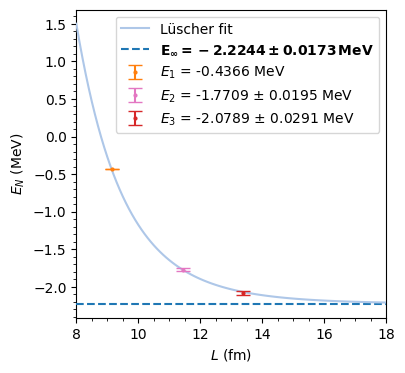

Infinite-basis extrapolated binding energy:  -2.2244  +-  0.0173  MeV ( 0.006 % off)


In [35]:
# List of trial energies
E_data = np.array([E_1_ex, E_2, E_3])
dE_data = np.array([0.001, dE_2, dE_3])
# Effective hard-wall radius for N=1, N=2 & N=3
L = np.array([9.14, 11.45, 13.38])  # fm

# Harmonic oscillator variant of Lüscher formula
#   k: bound state momentum fm^(-1)
#   gamma: asymptotic normalization coefficient fm^(-1/2)
def luscher(l, k, gamma):
    return -(hbar_c*hbar_c*k*k/(2*mu))*(1 - 2*gamma*gamma*np.exp(-2*k*l)/k - 4*(gamma**4)*l*np.exp(-4*k*l)/k)
            #hbar_c*hbar_c*k*gamma*gamma*(1- gamma*gamma/k - (gamma**4)/(4*k*k) + 2*w*k*(gamma**4))*np.exp(-4*k*l)/mu

# Fit to k and gamma
[k, gamma], cov = curve_fit(luscher, L, E_data, sigma = dE_data, absolute_sigma = True)
[dk, dgamma] = np.sqrt(np.diag(cov))
E_gs = -hbar_c*hbar_c*k*k/(2*mu)
dE_gs = hbar_c*hbar_c*k*dk/mu
#print(k, dk, gamma, dgamma)

# Fit plot
E_exact = -2.2245 #MeV
ll = np.arange(8,18.0001,0.1)
lbl = '$\\bf{E_\infty = ' + str(round(E_gs,4))  + ' \pm ' + str(round(dE_gs,4)) +'\,MeV}$'
lbl1 = '$E_1$ = ' + str(round(E_1_ex,4)) + ' MeV'
lbl2 = '$E_2$ = ' + str(round(E_2,4)) + ' $\pm$ ' + str(round(dE_2,4)) + ' MeV'
lbl3 = '$E_3$ = ' + str(round(E_3,4)) + ' $\pm$ ' + str(round(dE_3,4))+ ' MeV'
cmap = plt.get_cmap('tab20')
cmap2 = plt.get_cmap('tab20b')
w = 4
h = 4
plt.figure(figsize=(w,h))
plt.plot(ll, luscher(ll, k, gamma), color = cmap(1), zorder= 4, label= 'Lüscher fit')
plt.plot(ll, -hbar_c*hbar_c*k*k/(2*mu)*np.ones(len(ll)), '--', color = cmap(0), zorder = 3, label = lbl)
plt.errorbar(L[0], E_data[0], dE_data[0], color = cmap(2),fmt="o", ms=2, capsize = 5, zorder=5, linestyle = 'none',label = lbl1)
plt.errorbar(L[1], E_data[1], dE_data[1], color = cmap(12),fmt="o", ms=2, capsize = 5, zorder=5, linestyle = 'none',label = lbl2)
plt.errorbar(L[2], E_data[2], dE_data[2], color = cmap(6),fmt="o", ms=2, capsize = 5, zorder=5, linestyle = 'none',label = lbl3)
plt.legend()
plt.xlim(ll.min(), ll.max())
plt.minorticks_on()
plt.xlabel('$L$ (fm)')
plt.ylabel('$E_N$ (MeV)')
plt.show()
# Results
print('Infinite-basis extrapolated binding energy: ', round(E_gs,4), ' +- ', round(dE_gs,4),\
        ' MeV (', round(np.abs(100*(E_exact -E_gs)/E_exact),3),'% off)' )